# Importing the dependencies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from wordcloud import WordCloud
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the dataset

In [ ]:
latest_df = pd.read_csv("/content/drive/MyDrive/Hate_speech_detection_system/data_set/first_term_final_training_data.csv")

In [ ]:
# Shape of the dataframe
latest_df.shape

(15302, 2)

In [ ]:
# Unique category present in the data
latest_df['label'].unique()

array(['bias', 'hate_speech', 'normal', 'misinformation'], dtype=object)

In [ ]:
# Count of each unique category present in the data
label_counts = latest_df['label'].value_counts()
label_counts

,count
label,
normal,4904
hate_speech,4273
misinformation,3108
bias,3017


# Basic data distribution

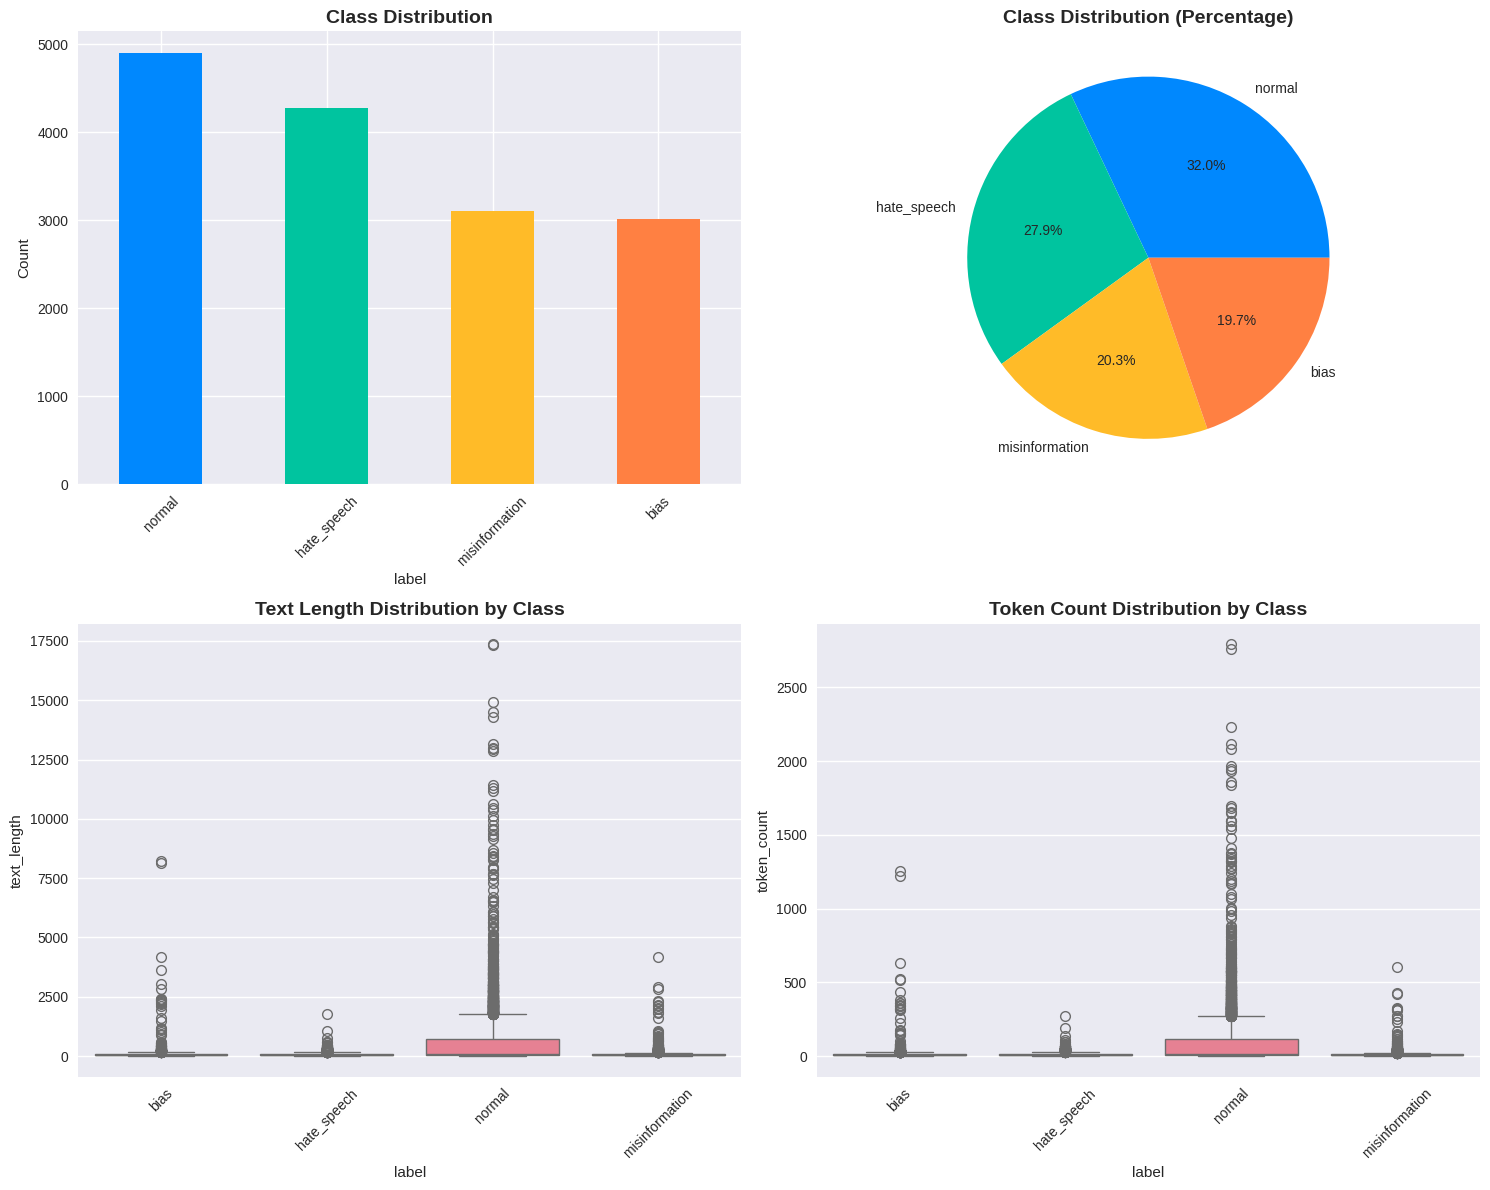

In [ ]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. Class Distribution
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
# fig, ax1 = plt.subplots(figsize=(8, 6))

# Bar plot
label_counts.plot(kind='bar', ax=ax1, color=['#0088FE', '#00C49F', '#FFBB28', '#FF8042'])
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%',
        colors=['#0088FE', '#00C49F', '#FFBB28', '#FF8042'])
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

# Text length analysis (you'll need to calculate this)
latest_df['text_length'] = latest_df['text'].str.len()
sns.boxplot(data=latest_df, x='label', y='text_length', ax=ax3)
ax3.set_title('Text Length Distribution by Class', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)

# Token count analysis
# Token count analysis with NaN handling
latest_df['token_count'] = latest_df['text'].fillna('').str.split().apply(len)
sns.boxplot(data=latest_df, x='label', y='token_count', ax=ax4)
ax4.set_title('Token Count Distribution by Class', fontsize=14, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)

# Imbalance visualization
# imbalance_ratio = label_counts.max() / label_counts.min()
# ax4.bar(['Imbalance Ratio'], [imbalance_ratio], color='coral')
# ax4.set_title(f'Class Imbalance Ratio: {imbalance_ratio:.2f}:1', fontsize=14, fontweight='bold')
# ax4.set_ylabel('Ratio')

plt.tight_layout()
plt.show()

# Applying oversampling to balance the dataset

In [ ]:

# Set target count for each class
target_count = latest_df['label'].value_counts().max()

# Create a list to store balanced data
balanced_df = []

# For each class, duplicate data as needed
for label in latest_df['label'].unique():
    class_df = latest_df[latest_df['label'] == label]
    if len(class_df) < target_count:
        class_df = class_df.sample(target_count, replace=True, random_state=42)  # Oversample
    else:
        class_df = class_df.sample(target_count, random_state=42)  # Undersample if needed

In [ ]:
# Count original labels
label_counts = latest_df['label'].value_counts()
print(label_counts)

# Set target count for each class
# target_count = label_counts.max()
target_count = 5000

# Create a list to store balanced data
balanced_df_list = []

# For each class, duplicate data as needed
for label in latest_df['label'].unique():
    class_df = latest_df[latest_df['label'] == label]
    if len(class_df) < target_count:
        class_df = class_df.sample(target_count, replace=True, random_state=42)  # Oversample
    else:
        class_df = class_df.sample(target_count, random_state=42)  # Undersample if needed
    balanced_df_list.append(class_df)

# Combine all balanced class data into one DataFrame
df_balanced = pd.concat(balanced_df_list).reset_index(drop=True)

label
normal            4904
hate_speech       4273
misinformation    3108
bias              3017
Name: count, dtype: int64


In [ ]:
# Now you can safely access 'label'
df_balanced['label'].value_counts()

,count
label,
bias,5000
hate_speech,5000
normal,5000
misinformation,5000


# Encode string labels to integers

In [ ]:
label_encoder = LabelEncoder()
df_balanced['label'] = label_encoder.fit_transform(df_balanced['label'])

# Save label mapping for future use
label2id = {label: idx for idx, label in enumerate(label_encoder.classes_)}
id2label = {idx: label for label, idx in label2id.items()}

In [ ]:
label2id

{'bias': 0, 'hate_speech': 1, 'misinformation': 2, 'normal': 3}

# Training metrics visualization tool

In [ ]:
!pip install wandb
# 3d3e348d51aca106577d4475eaae33ca9a770d37

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: joshi2055lalit (joshi2055lalit-zakipoint-health) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:

print(f"CUDA Available: {torch.cuda.is_available()}")
# print(f"GPU: {torch.cuda.get_device_name(0)}")import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
# print(f"GPU: {torch.cuda.get_device_name(0)}")

CUDA Available: True
CUDA Available: True


# Common utils

In [ ]:
# 8. Define compute_metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
# Preprocessing function
def preprocess_function(examples, tokenizer):
    texts = [str(t) if t is not None else "" for t in examples["text"]]
    return tokenizer(
        texts,
        padding=True,          # Pad to longest in batch
        truncation=True,       # Truncate to model's max length
        max_length=512,        # Optional: set your max length
        return_tensors="pt"
    )

In [ ]:
def train_transformer_model(
    model_name: str,
    df,
    num_labels: int,
    preprocess_function,
    output_dir: str,
    compute_metrics=None,
    test_size: float = 0.1,
    batch_size: int = 20,
    num_train_epochs: int = 10,
    learning_rate: float = 1e-5,
    weight_decay: float = 0.1,
    warmup_steps: int = 500,
    fp16: bool = True,
    gradient_accumulation_steps: int = 2,
    logging_steps: int = 100,
    eval_steps: int = 200,
    save_steps: int = 1200,
    save_total_limit: int = 3,
):
    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
    print(f"Model '{model_name}' loaded successfully!")

    # Convert dataframe to Dataset object and split
    dataset = Dataset.from_pandas(df)
    dataset = dataset.train_test_split(test_size=test_size)

    # Tokenize the dataset
    # tokenized_dataset = dataset.map(preprocess_function, batched=True)
    tokenized_dataset = dataset.map(
    lambda x: preprocess_function(x, tokenizer=tokenizer),
    batched=True
    )

    # Inspect one sample (optional)
    print("Sample tokenized data:", tokenized_dataset["train"][0])

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=output_dir,
        eval_strategy="steps",
        eval_steps=eval_steps,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=num_train_epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        logging_steps=logging_steps,
        save_steps=save_steps,
        save_total_limit=save_total_limit,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        greater_is_better=False,
        fp16=fp16,
        dataloader_drop_last=True,
        gradient_accumulation_steps=gradient_accumulation_steps
    )

    # Prepare collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # Setup trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # Train the model
    print("Starting fine-tuning...")
    train_result = trainer.train()
    print("Fine-tuning complete!")

    return trainer, train_result, tokenizer, tokenized_dataset

In [ ]:
def evaluate_and_plot_results(trainer, train_result, tokenized_test_set, class_names=None):
    # 1. Save model and tokenizer (optional)
    # trainer.save_model("your_save_path")
    # trainer.tokenizer.save_pretrained("your_save_path")

    # 2. Evaluate metrics
    metrics = trainer.evaluate()
    print("Evaluation Metrics:", metrics)

    # 3. Extract training and evaluation losses
    logs = trainer.state.log_history
    train_loss_vals = [log["loss"] for log in logs if "loss" in log]
    eval_loss_vals = [log["eval_loss"] for log in logs if "eval_loss" in log]

    epochs_train = list(range(1, len(train_loss_vals) + 1))
    epochs_eval = list(range(1, len(eval_loss_vals) + 1))

    # 4. Plot losses
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_train, train_loss_vals, label="Training Loss")
    plt.plot(epochs_eval, eval_loss_vals, label="Evaluation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Evaluation Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    # 5. Get predictions
    predictions = trainer.predict(tokenized_test_set)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_true = predictions.label_ids

    # 6. Plot Confusion Matrix
    if class_names is None:
        class_names = list(set(y_true))  # default class names

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

    return metrics, y_true, y_pred

# Finetuning Indic Bert

In [ ]:
# Call the function with your inputs
trainer, train_result, tokenizer, tokenized_dataset = train_transformer_model(
    model_name="ai4bharat/indic-bert",
    df=df_balanced,
    num_labels=4,
    preprocess_function=preprocess_function,
    output_dir="/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/indic_bert/training_checkpoints",
    compute_metrics=compute_metrics,  # your custom metric function
    num_train_epochs= 10
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

You are using a model of type albert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/135M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/135M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai4bharat/indic-bert and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.

Model 'ai4bharat/indic-bert' loaded successfully!


Map:   0%|          | 0/17654 [00:00<?, ? examples/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

Sample tokenized data: {'text': 'Fat men are funny.', 'label': 0, 'input_ids': [2, 29088, 4621, 150, 80995, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/tmp/ipython-input-538484370.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting fine-tuning...


wandb: Currently logged in as: joshi2055lalit (joshi2055lalit-zakipoint-health) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,1.199400,1.071594,0.570918,0.635802,0.570918,0.556992
400,0.845100,0.855554,0.680612,0.729755,0.680612,0.661361
600,0.669200,0.605746,0.770918,0.781223,0.770918,0.767255
800,0.581600,0.505532,0.816327,0.820295,0.816327,0.815036
1000,0.437800,0.553202,0.795918,0.820229,0.795918,0.797533
1200,0.435100,0.404543,0.863265,0.864752,0.863265,0.862203
1400,0.369800,0.457756,0.838776,0.867189,0.838776,0.839733
1600,0.306700,0.348656,0.881122,0.883691,0.881122,0.881082
1800,0.269500,0.327057,0.887245,0.890590,0.887245,0.887077
2000,0.243200,0.425398,0.858673,0.877261,0.858673,0.857500


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

Fine-tuning complete!


In [ ]:
# 12. Save model and tokenizer
trainer.save_model("/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/indic_bert/models/model")
tokenizer.save_pretrained("/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/indic_bert/models/tokenizer")

('/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/indic_bert/models/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/indic_bert/models/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/indic_bert/models/tokenizer/spiece.model',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/indic_bert/models/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/indic_bert/models/tokenizer/tokenizer.json')

##### Evaluate and plot metrices

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Evaluation Metrics: {'eval_loss': 0.40454304218292236, 'eval_accuracy': 0.863265306122449, 'eval_precision': 0.8647521425305712, 'eval_recall': 0.863265306122449, 'eval_f1': 0.8622025137156463, 'eval_runtime': 15.9593, 'eval_samples_per_second': 122.938, 'eval_steps_per_second': 6.203, 'epoch': 10.0}


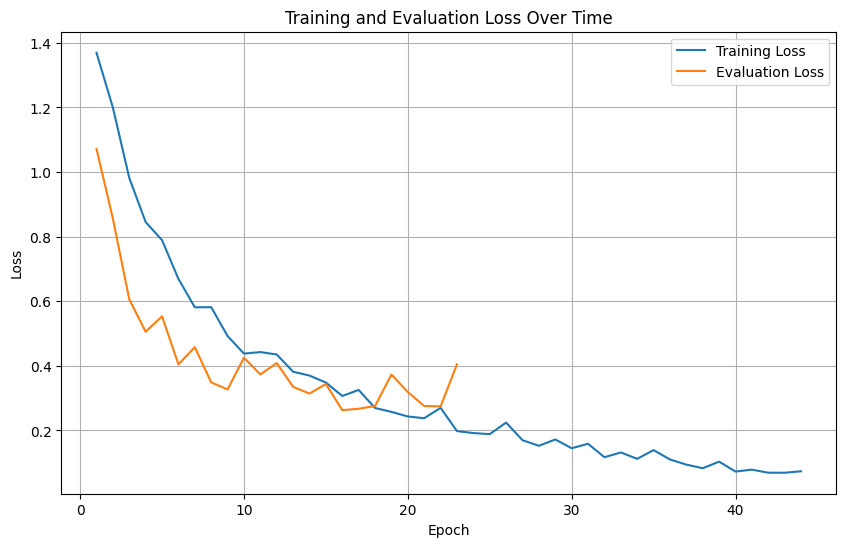

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


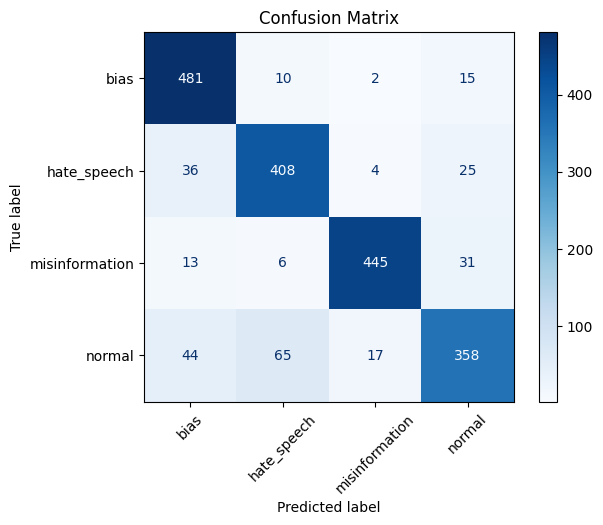

In [ ]:
class_names = ["bias", "hate_speech", "misinformation", "normal"]

metrics, y_true, y_pred = evaluate_and_plot_results(
    trainer=trainer,
    train_result=train_result,
    tokenized_test_set=tokenized_dataset["test"],
    class_names=class_names
)


# Finetuning mBert

In [ ]:
# Call the function with your inputs
trainer, train_result, tokenizer, tokenized_dataset = train_transformer_model(
    model_name="bert-base-multilingual-cased",
    df=df_balanced,
    num_labels=4,
    preprocess_function=preprocess_function,
    output_dir="/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/mBert/training_checkpoints",
    compute_metrics=compute_metrics,  # your custom metric function
    num_train_epochs= 10
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model 'bert-base-multilingual-cased' loaded successfully!


Map:   0%|          | 0/17654 [00:00<?, ? examples/s]

Map:   0%|          | 0/1962 [00:00<?, ? examples/s]

Sample tokenized data: {'text': 'मधेशी समुदायका व्यक्तिहरूमा परम्परागत सोचाइ नै बलियो हुन्छ, त्यसैले उनीहरूलाई आधुनिक नेतृत्वमा देखाउनु गलत हो।', 'label': 0, 'input_ids': [101, 889, 97451, 35593, 898, 13841, 14070, 102299, 15399, 53025, 37392, 12347, 12213, 45753, 61533, 74610, 11845, 898, 13718, 22078, 34231, 59029, 887, 11714, 43237, 40108, 117, 880, 14251, 13432, 18438, 13665, 71937, 37392, 26377, 67898, 13088, 11845, 37500, 27155, 12347, 95730, 62132, 14070, 867, 11714, 11845, 13220, 920, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/tmp/ipython-input-538484370.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting fine-tuning...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,1.108400,0.817178,0.732143,0.760024,0.732143,0.716920
400,0.501600,0.432217,0.846939,0.846562,0.846939,0.843538
600,0.379700,0.330951,0.878061,0.882293,0.878061,0.878468
800,0.326500,0.288435,0.897959,0.897615,0.897959,0.897146
1000,0.227600,0.234945,0.912245,0.911990,0.912245,0.911985
1200,0.204500,0.217026,0.927551,0.926699,0.927551,0.926804
1400,0.164300,0.285972,0.916327,0.916335,0.916327,0.915190
1600,0.133600,0.203680,0.938776,0.938405,0.938776,0.937923
1800,0.115600,0.190602,0.941327,0.940863,0.941327,0.940950
2000,0.096800,0.243649,0.932653,0.931935,0.932653,0.931844


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

Fine-tuning complete!


In [ ]:
# 12. Save model and tokenizer
trainer.save_model("/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/mBert/models/model")
tokenizer.save_pretrained("/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/mBert/models/tokenizer")

('/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/mBert/models/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/mBert/models/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/mBert/models/tokenizer/vocab.txt',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/mBert/models/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/mBert/models/tokenizer/tokenizer.json')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Evaluation Metrics: {'eval_loss': 0.21702612936496735, 'eval_accuracy': 0.9275510204081633, 'eval_precision': 0.9266989858176075, 'eval_recall': 0.9275510204081633, 'eval_f1': 0.9268038560929148, 'eval_runtime': 16.4137, 'eval_samples_per_second': 119.534, 'eval_steps_per_second': 6.032, 'epoch': 10.0}


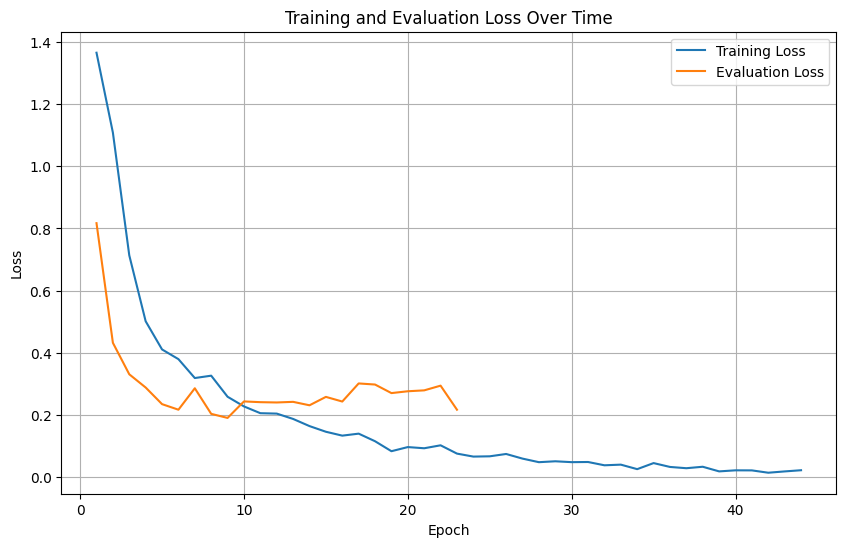

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


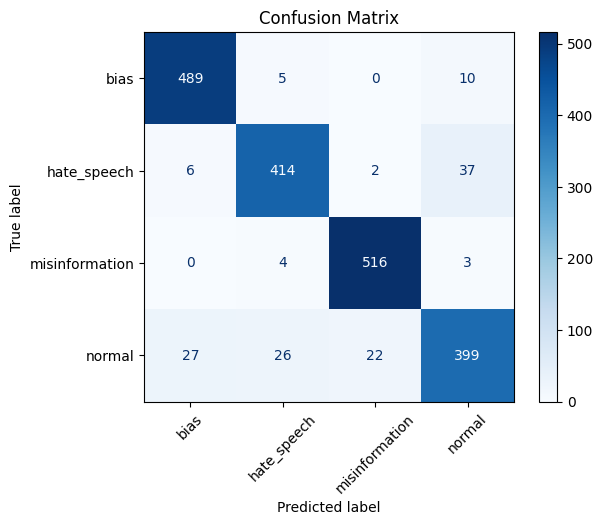

In [ ]:
class_names = ["bias", "hate_speech", "misinformation", "normal"]

metrics, y_true, y_pred = evaluate_and_plot_results(
    trainer=trainer,
    train_result=train_result,
    tokenized_test_set=tokenized_dataset["test"],
    class_names=class_names
)


# xlm-RoBERTa

In [ ]:
# Call the function with your inputs
trainer, train_result, tokenizer, tokenized_dataset = train_transformer_model(
    model_name="xlm-roberta-base",
    df=df_balanced,
    num_labels=4,
    preprocess_function=preprocess_function,
    output_dir="/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/xlm_roberta/training_checkpoints",
    compute_metrics=compute_metrics,  # your custom metric function
    num_train_epochs= 10
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

You are using a model of type xlm-roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output.Laye

Model 'xlm-roberta-base' loaded successfully!


Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Sample tokenized data: {'text': 'नेपालमा हालैको सार्वजनिक स्वास्थ्य सुधार कार्यक्रमलाई गुप्त रूपमा डेटा चोरीको लागि प्रयोग गरिएको छ।', 'label': 2, 'input_ids': [0, 36172, 213497, 356, 19761, 20202, 40684, 10550, 1385, 202298, 47686, 138639, 116540, 356, 2944, 16872, 13016, 848, 125, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

/tmp/ipython-input-538484370.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Starting fine-tuning...


wandb: Currently logged in as: joshi2055lalit (joshi2055lalit-zakipoint-health) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
200,1.325100,1.206677,0.490000,0.574589,0.490000,0.468467
400,0.893800,0.885011,0.649500,0.736822,0.649500,0.647485
600,0.612700,0.494293,0.825500,0.827740,0.825500,0.824509
800,0.481300,0.382174,0.863500,0.863753,0.863500,0.863259
1000,0.391900,0.342239,0.877000,0.878317,0.877000,0.876851
1200,0.349200,0.296963,0.897000,0.898575,0.897000,0.896725
1400,0.307300,0.292284,0.903000,0.909486,0.903000,0.904009
1600,0.247600,0.237193,0.917500,0.918898,0.917500,0.917672
1800,0.259100,0.228729,0.918500,0.918539,0.918500,0.918305
2000,0.192300,0.256209,0.913000,0.917101,0.913000,0.913943


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packa

Fine-tuning complete!


In [ ]:
# 12. Save model and tokenizer
trainer.save_model("/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/xlm_roberta/models/model")
tokenizer.save_pretrained("/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/xlm_roberta/models/tokenizer")

('/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/xlm_roberta/models/tokenizer/tokenizer_config.json',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/xlm_roberta/models/tokenizer/special_tokens_map.json',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/xlm_roberta/models/tokenizer/sentencepiece.bpe.model',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/xlm_roberta/models/tokenizer/added_tokens.json',
 '/content/drive/MyDrive/Hate_speech_detection_system/over_sample_data_train_models/xlm_roberta/models/tokenizer/tokenizer.json')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Evaluation Metrics: {'eval_loss': 0.18266229331493378, 'eval_accuracy': 0.9505, 'eval_precision': 0.9503512799286826, 'eval_recall': 0.9505, 'eval_f1': 0.9503921691704899, 'eval_runtime': 14.9612, 'eval_samples_per_second': 133.679, 'eval_steps_per_second': 6.684, 'epoch': 10.0}


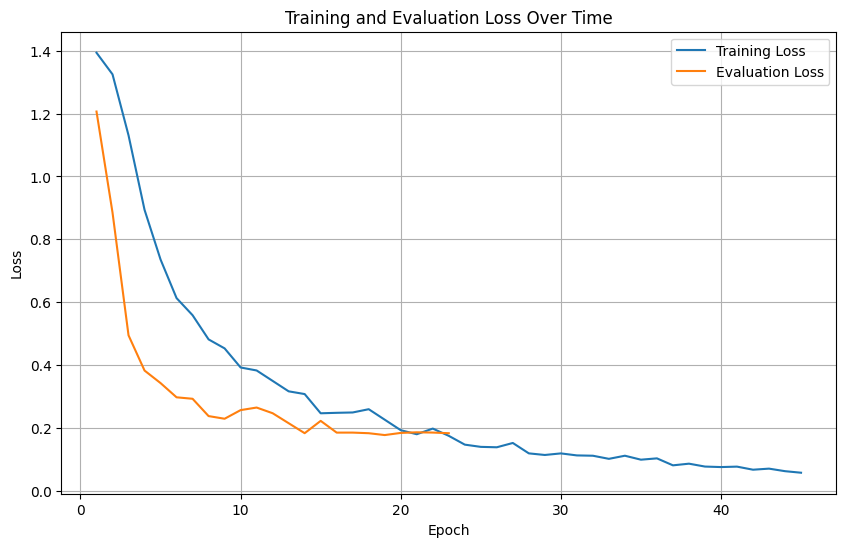

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


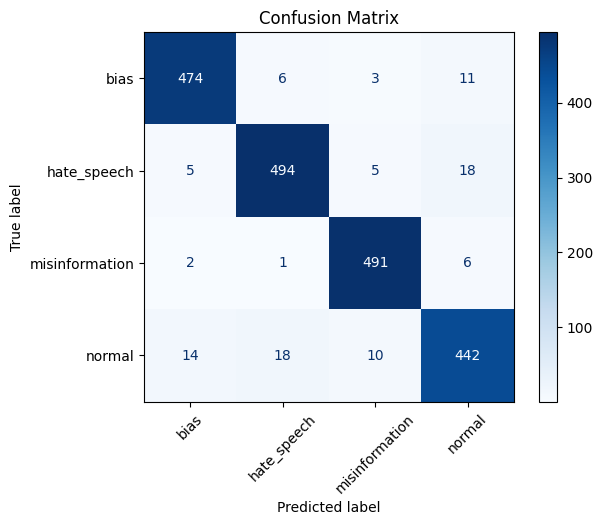

In [ ]:
class_names = ["bias", "hate_speech", "misinformation", "normal"]

metrics, y_true, y_pred = evaluate_and_plot_results(
    trainer=trainer,
    train_result=train_result,
    tokenized_test_set=tokenized_dataset["test"],
    class_names=class_names
)
